In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 20 09:42:10 2020

@author: rhoover
"""

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community
from t_svd import *
from networkx.generators.community import LFR_benchmark_graph
from networkx.linalg import *

##  Tensor packages for Tucker, etc.  ###
from sktensor.tucker import hooi
from sktensor import dtensor

### Standard Linear Algebra Package  ###
from scipy import linalg

from sympy import *

In [2]:
plt.close()

N = 20 # Time steps
n = 20 # Nodes
p = .4
c = 2

adj = np.zeros([n,n,2*N+2])

In [3]:
# Create random graph and store to the last lateral slice of adj
G = nx.fast_gnp_random_graph(n,p,seed = 4652, directed = False)
G_adj = nx.to_numpy_matrix(G)
adj[0:n,0:n,0] = G_adj # Stoer the first adjacency matrix in the first frontal slice of adj

In [4]:
# Create another random graph and store to the last lateral slice of adj
#G = nx.fast_gnp_random_graph(n,p,seed = 4652, directed = False)
#G_adj = nx.to_numpy_matrix(G)
adj[0:n,0:n,(2*N+2) - 1] = G_adj # Store the last adjacency matrix in the last frontal slice of adj

In [5]:
#  Generate graph community over 20 graphs.
for i in range(1,N+1):
    q = p-p*i/(N+1)
    P = np.array([[p,q],[q,p]])
    Gsbm = nx.to_numpy_matrix(nx.stochastic_block_model([int(n/c),int(n/c)],P))
    adj[0:n,0:n,i] = Gsbm
    #print(i)

In [6]:
###  Generate back end (from communities to single community) - and plot in the loop
eps = 0.0
print('The j vector')
for j in range(1,N+2):
    q = p*(j-1)/(N+2) + eps#remove the eps for complete dissconnectivity #
    P = np.array([[p,q],[q,p]])
    Gsbm = nx.to_numpy_matrix(nx.stochastic_block_model([int(n/c),int(n/c)],P))
    adj[0:n,0:n,i+j] = Gsbm
    #print(i+j)

The j vector


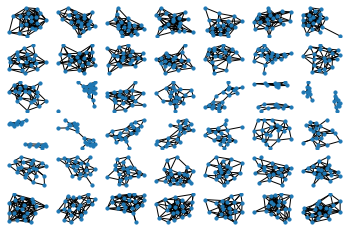

In [7]:
####  Visualization of the graphs
plt.figure(1)
for i in range(2*N+2):
    plt.subplot(6,7,i+1)
    nx.draw(nx.from_numpy_matrix(adj[0:n,0:n,i]),node_size = 10)

In [8]:
lap = laplacian_matrix(nx.from_numpy_matrix(adj[:, :, 21]))
lap = lap.toarray()

In [10]:

mat = Matrix(lap.astype(int))
print(mat.has(Float))
#mat = Matrix(lap)

eigs = mat.eigenvals(error_when_incomplete=False)
print(eigs)

P, J = mat.jordan_form(error_when_incomplete=False)

False
{3: 1, 4: 2, 5 - sqrt(3): 1, sqrt(3) + 5: 1, 7/2 - sqrt(5)/2: 1, sqrt(5)/2 + 7/2: 1, 3 + 2/(1/2 + sqrt(31)*I/2)**(1/3) + (1/2 + sqrt(31)*I/2)**(1/3): 1, 3 + 2/((-1/2 + sqrt(3)*I/2)*(1/2 + sqrt(31)*I/2)**(1/3)) + (-1/2 + sqrt(3)*I/2)*(1/2 + sqrt(31)*I/2)**(1/3): 1, 3 + (-1/2 - sqrt(3)*I/2)*(1/2 + sqrt(31)*I/2)**(1/3) + 2/((-1/2 - sqrt(3)*I/2)*(1/2 + sqrt(31)*I/2)**(1/3)): 1, 4 - sqrt(5/2 - sqrt(17)/2): 1, 4 - sqrt(sqrt(17)/2 + 5/2): 1, sqrt(5/2 - sqrt(17)/2) + 4: 1, sqrt(sqrt(17)/2 + 5/2) + 4: 1, 15/4 + sqrt(107/6 - 2*(2044/27 + sqrt(61062)*I/36)**(1/3) - 3/(4*sqrt(107/12 + 323/(9*(2044/27 + sqrt(61062)*I/36)**(1/3)) + 2*(2044/27 + sqrt(61062)*I/36)**(1/3))) - 323/(9*(2044/27 + sqrt(61062)*I/36)**(1/3)))/2 - sqrt(107/12 + 323/(9*(2044/27 + sqrt(61062)*I/36)**(1/3)) + 2*(2044/27 + sqrt(61062)*I/36)**(1/3))/2: 1, 15/4 - sqrt(107/12 + 323/(9*(2044/27 + sqrt(61062)*I/36)**(1/3)) + 2*(2044/27 + sqrt(61062)*I/36)**(1/3))/2 - sqrt(107/6 - 2*(2044/27 + sqrt(61062)*I/36)**(1/3) - 3/(4*sqrt

KeyboardInterrupt: 

In [ ]:
s = Symbol('s')
p = (s * eye(20) - lap).det()